# pset10: the adventure of the moonlighting genes
*by Xingyu (Luna) Li , Nov 15th, 2021*
  
## Background
There seem to be a small number of gene batteries (modules of co-expressed genes) that are mixed and matched at different levels to specify the basic morphological properties of different sand mouse neuron cell types.   
We have collected RNA-seq data (as mapped read counts) for 60 different purified neuronal cell types and are trying to deduce the gene batteries using the NMF methods. 

## 1. Write a function that simulates positive control data
First, we are going to write a function that generates synthetic data for N genes and M experiments, generated from R underlying gene batteries.

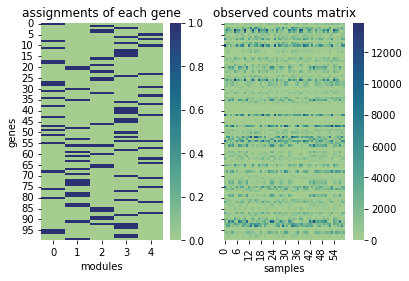

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate synthetic data
def simulator(N, M, R, n = 3):
    """input
            N: number of genes
            M: number of experiments
            R: number of gene batteries
            n: number of moonlight genes
        output
            V_obs: observed counts matrix (NxM)
            V_exp: expected counts matrix (NxM)
            assign: the assignment of each gene (NxR)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
            C: total number of counts per experiment (Mx1)
    """
    # For each gene, decide which module it belongs to
    assign = np.zeros((N,R))
    idx = np.random.choice(N, n) # choose the index of moonlight genes
    for i in range(N):
        if i in idx:
            assign[i] = np.array([1]*2 + [0] * (R-2))
            np.random.shuffle(assign[i])
        else:
            assign[i] = np.array([1] + [0] * (R-1))
            np.random.shuffle(assign[i])
    
    # Initialize W
    W = assign.astype(float)
    for i in range(W.shape[1]):
        c = W[:,i]
        c[c > 0] = np.random.dirichlet(c[c > 0])
    
    # Initialize H
    H = np.random.dirichlet(np.ones(R), size=M).T
    
    # Initialize C_mu
    C_mu = np.random.normal(loc = 100000, scale = 5000, size = M)
    
    # Calculate lambda
    V_exp = C_mu * (W @ H)
    
    # Calculate simulated V
    V_obs = np.random.poisson(V_exp)
    
    # Calculate C by summing over the columns of V_obs
    C = np.sum(V_obs, axis = 0)
    
    return V_obs, V_exp, assign, W, H, C

# Generate our data of 100 genes, 60 experiments and 5 gene batteries
np.random.seed(9)
V_obs, V_exp, assign, W, H, C = simulator(100, 60, 5)

# Visualize the assignments of each gene
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
g1 = sns.heatmap(assign, cmap = "crest", ax=ax1)
g1.set_title("assignments of each gene")
g1.set_xlabel("modules")
g1.set_ylabel("genes")

g2 = sns.heatmap(V_obs, cmap = "crest", ax=ax2)
g2.set_title("observed counts matrix")
g2.set_xlabel("samples")

plt.show()

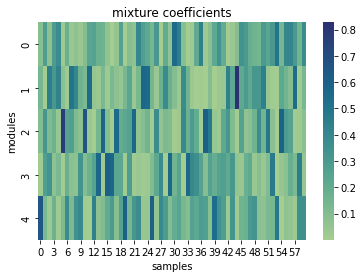

In [2]:
# Visualize the mixture coefficients of each module in each sample
g = sns.heatmap(H, cmap = "crest")
g.set_title("mixture coefficients")
g.set_xlabel("samples")
g.set_ylabel("modules")
plt.show()

The heatmap shows that our simulator works fine.

## 2. Implement nonnegative matrix factorization
Next, we want to use NMF to decompose the data into information about the proportion of genes in each gene batteries and information about the sample expression level of each gene batteries.

In [3]:
def NMF(V_obs, R, epsilon):
    # Initialize W and H to random guesses
    W = np.random.dirichlet(np.ones(V_obs.shape[0]), size = R).T
    H = np.random.dirichlet(np.ones(R), size = V_obs.shape[1]).T

    # Calculate C by summing the columns of V
    C = np.sum(V_obs, axis = 0)

    # Calculate the expected counts V_exp from C, W, and H
    V_exp = C[np.newaxis,:] * (W @ H)

    # Check for convergence using epsilon
    ll_old = -np.inf
    ll = 0
    ll_list = []
    
    while ll - ll_old > epsilon:
        ll_old = ll

        # Update W and H
        W_new = W * (V_obs/V_exp @ (C[:,np.newaxis] * (H.T)))
        W_new = W_new/np.sum(W_new, axis = 0) # normalize so the columns sum to 1
        H_new = H * ((V_obs/V_exp).T @ W).T
        W, H = W_new, H_new

        # Calculate the expected counts V_exp
        V_exp = C[np.newaxis,:] * (W @ H)

        # Calculate the log likelihood using observed counts and expected counts  
        ll = V_obs * np.log(V_exp) - V_exp
        ll = np.sum(ll)
        ll_list.append(ll)
    
    return W, H, ll_list

## 3. Test our implementation
Next, we want to apply our NMF function to synthetic datasets that we generate, varying the parameters of the synthetic data and see if it works well.

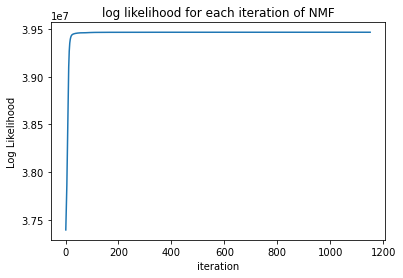

In [4]:
# Generate our data of 100 genes, 60 experiments and 5 gene batteries
np.random.seed(0)
V_obs, V_exp, assign_real, W_real, H_real, C_real = simulator(100, 60, 5)

# Apply the NMF algorithm using R = 5
W, H, ll_list = NMF(V_obs, 5, epsilon = 0.01)
    
# Visualize the log likelihood at each iteration
import matplotlib.pyplot as plt
def visulize_ll(ll_list, object, x_start = 1):
    i = range(x_start,len(ll_list)+x_start)
    plt.plot(i, ll_list)
    plt.xlabel(object) 
    plt.ylabel("Log Likelihood")  
    plt.title("log likelihood for each {} of NMF".format(object))  
    plt.show()
visulize_ll(ll_list, "iteration")

We can see that our log likelihood reached its maximum within 200 iterations, so we may set our epsilon to a larger number in future analysis.

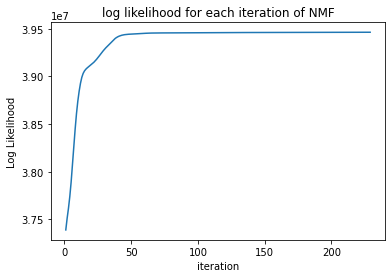

In [5]:
# NMF using R = 5 and epsilon = 10
W, H, ll_list = NMF(V_obs, 5, epsilon = 10)
visulize_ll(ll_list, "iteration")

We also want to change the number of gene batteries we assumed in sandmouse genome to decide the best R.

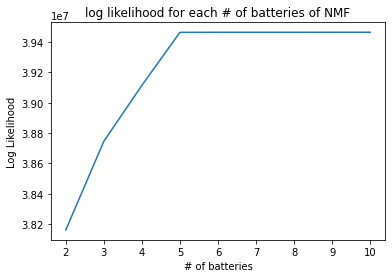

In [6]:
# Define a function to return ll_list for different # of batteries
def n_batteries(V_obs, start_n, end_n):
    iteration = range(start_n, end_n + 1)
    ll_list = np.zeros(len(iteration))
    for i in iteration:
        ll_list[i-start_n] = NMF(V_obs, i, epsilon = 10)[2][-1]
    return ll_list
ll_list = n_batteries(V_obs, 2, 10)
visulize_ll(ll_list, "# of batteries", x_start = 2)

We can see that the log likelihood increases drastically when number of gene batteries increase from 2 to 5, and remains relatively the same from R = 5 to 10, indicating that there are mostly likely to be 5 gene batteries.   
   
Next, we want to plot the ROC curve to see if our model works well.   
However, the results of the NMF algorithm are randomly arranged on the column, and we first need to find the correct order (which would have the largest AUC) through  all possible permutations before we can compare with the real gene assignment.

In [7]:
# Define a function to give out classification results according to different thresholds
def classification_results(scores, labels, granularity):
    thresholds = np.linspace(min(scores),max(scores),granularity) # iterate through max to min of scores
    FPR = []; TPR = []
    for threshold in thresholds:
        TP, FP, FN, TN = np.zeros(4)  # initialize the classification counts
        for i in range(len(scores)):  # iterate through each scores and labels
            if scores[i] > threshold:
                if labels[i] == 1:
                    TP += 1           # true positive
                else: FP += 1         # false positive
            elif labels[i] == 1: 
                FN += 1               # false negative
            else: TN += 1             # true negative
        FPR.append(FP / (TN + FP))
        TPR.append(TP / (TP + FN))
    return FPR, TPR

# Find the correct order through comparison of AUCs
import itertools
from numpy import trapz
labels = assign_real.flatten()        # the real labels
idx = list(itertools.permutations(range(W.shape[1]))) # index of permutations of all columns
auc = []
for i in idx:
    shuffled = W[:,i]                 # the shuffled W
    scores = shuffled.flatten()      
    FPR, TPR = classification_results(scores, labels, 1000)
    auc.append(1 - abs(trapz(FPR, TPR, dx=0.001))) 
order = idx[auc.index(max(auc))]      # the correct order with the largest AUC
order

(0, 1, 3, 2, 4)

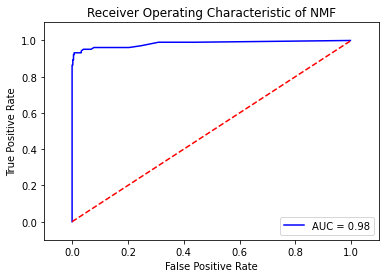

In [8]:
# Draw the ROC plot
W_ordered = W[:,order]
labels = assign_real.flatten()
scores = W_ordered.flatten()

# Calculate the TPR and FPR
FPR, TPR = classification_results(scores, labels, 1000)
    # or there's a 'metrics' module in sklearn: FPR, TPR, thresholds = metrics.roc_curve(labels, scores)

# Calculate the Area Under Curve
auc = 1 - abs(trapz(FPR, TPR, dx=0.001))
    # or auc = metrics.auc(fpr, tpr) 

# Draw the ROC plot
plt.title('Receiver Operating Characteristic of NMF')
plt.plot(FPR, TPR, 'b', label = 'AUC = %0.2f' % auc)  # draw the ROC curve and label the AUC
plt.legend(loc = 'lower right')  
plt.plot([0, 1], [0, 1],'r--')         # draw a reference line of y = x
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

An AUC close to 1.0 indicates that our NMF algorithm have perfect discriminating ability to assign all genes to different gene batteries correctly.

## 4. Analyze the Adler data
Finally, we would apply our NMF analysis to the Adler dataset and try to identifye gene batteries, including shared genes between batteries.

In [9]:
# Import the Adler data
V = [] ; genes = []
with open("w10-data.tbl") as f:
    for n,line in enumerate(f):
        fields = line.split()
        genes.append(fields[0])
        V.append([int(i) for i in fields[1:]])
V = np.array(V) 

# Check the dimensions of V
print('The dimensions are:  %i x %i' % (V.shape[0], V.shape[1]))

The dimensions are:  100 x 60


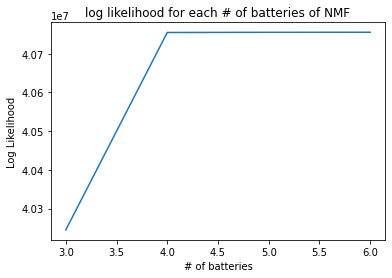

In [10]:
# Apply the NMF analysis
# First we want to decide the R
ll_list = n_batteries(V, 3, 6)
visulize_ll(ll_list, "# of batteries", x_start = 3)

We can see that the 'shoulder' of the log likelihood plot is at R = 4, so the number of genetic batteries is most likely four.  
(As the model complexity increases, the log likelihood inevitably increases, but it increases most quickly before R = 4, and then the log likelihood increases little as R increases, so 4 is the most reasonable choice.)

Text(0, 0.5, 'Frequency')

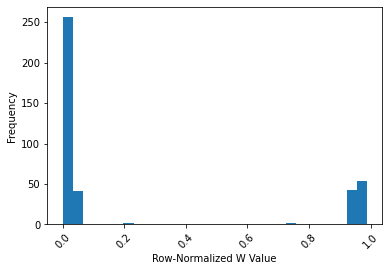

In [11]:
# Run NMF using R = 4
W, H, ll_list = NMF(V, 4, epsilon = 10)

# Normalize W through the rows
W = W / W.sum(axis=1, keepdims=True)

# Plot the distribution of W
plt.hist(W.flatten(), bins=30)
plt.xticks(rotation=45)
plt.xlabel('Row-Normalized W Value')
plt.ylabel('Frequency')

After row-normalize W, we can see that a majority of W values are near zero and a small fraction (about 1/R as we expected) of them are near 1.0.   
Therefore, we would next set a threshold to make the values binary. Since there are several W values around .2 and .7, they may be moonlight genes, so we would like to set a threshold of .2 to keep them.

In [17]:
# Convert W to binary
W_binary = np.where(W > 0.2, 1, 0)
print(W_binary)

[[0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 1 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]

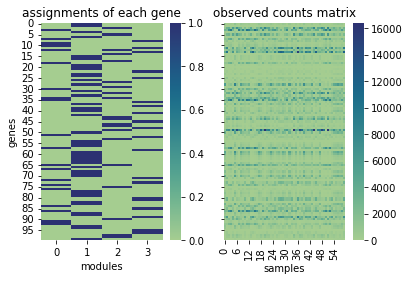

In [18]:
# Visualize the results and our data
f,(ax1,ax2) = plt.subplots(1,2,sharey=True)
g1 = sns.heatmap(W_binary, cmap = "crest", ax=ax1)
g1.set_title("assignments of each gene")
g1.set_xlabel("modules")
g1.set_ylabel("genes")

g2 = sns.heatmap(V, cmap = "crest", ax=ax2)
g2.set_title("observed counts matrix")
g2.set_xlabel("samples")

plt.show()

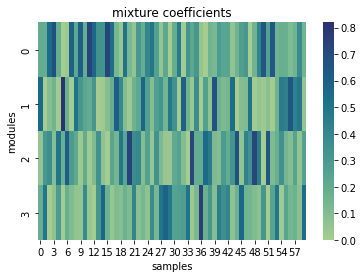

In [14]:
# Visualize the mixture coefficients of each module in each sample
g = sns.heatmap(H, cmap = "crest")
g.set_title("mixture coefficients")
g.set_xlabel("samples")
g.set_ylabel("modules")
plt.show()

In [15]:
# More detailed analysis of the results
# Genes in each battery
for bat in range(4):
    n_gene = np.sum(W_binary,axis = 0)[bat] # number of genes in each battery
    bat_gene = []
    for i in range(W.shape[0]):       # iterate through each gene
        if W_binary[i][bat] == 1:     # W_binary = 1 indicates that gene belong to the battery
            bat_gene.append(genes[i]) # return the gene names
    print("There are {} genes in battery {} :\n {} \n".format(n_gene,bat,bat_gene))

There are 20 genes in battery 0 :
 ['arugula', 'basil', 'blackberry', 'blueberry', 'butternut', 'cayenne', 'currant', 'fennel', 'fig', 'lettuce', 'mushroom', 'papaya', 'parsnip', 'persimmon', 'plantain', 'pomegranate', 'rosemary', 'sage', 'tangerine', 'thyme'] 

There are 43 genes in battery 1 :
 ['anise', 'apricot', 'asparagus', 'banana', 'caraway', 'carrot', 'celery', 'chard', 'cherry', 'chickpea', 'cilantro', 'coconut', 'cranberry', 'eggplant', 'endive', 'ginger', 'grape', 'grapefruit', 'honeydew', 'lentil', 'mango', 'melon', 'mulberry', 'nectarine', 'okra', 'olive', 'onion', 'orange', 'oregano', 'parsley', 'pea', 'peach', 'pear', 'potato', 'pumpkin', 'quince', 'raspberry', 'rhubarb', 'scallion', 'spinach', 'tomato', 'turnip', 'zucchini'] 

There are 20 genes in battery 2 :
 ['artichoke', 'avocado', 'butternut', 'cantaloupe', 'cauliflower', 'coriander', 'cucumber', 'elderberry', 'fennel', 'horseradish', 'huckleberry', 'kiwi', 'kohlrabi', 'leek', 'maize', 'papaya', 'plum', 'tamarind'

In [19]:
# Moonlight genes
moonlight = []
for i,gene in enumerate(genes):
    if np.sum(W_binary,axis = 1)[i] > 1:
        moonlight.append(gene)
print("There are {} moonlight genes:\n {} ".format(len(moonlight),moonlight))

There are 3 moonlight genes:
 ['butternut', 'fennel', 'papaya'] 
